# EEG Signal Processing using Pytorch Project on CP DSAI Course

The project is to do classification on EEG signal using BCI Motor Imagery Dataset. 

In [1]:
!pip install mne

In [1]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np

# from google.colab import drive

# Modeling and training packages
import torch
from torch import nn
import torch.optim as optim

# Data Preparation packages
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

#Configurations
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1. Dataset Retrival

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Because the dataset was loaded to Google drive directory, mounting that directory

Define dataset path. The dataset path should be the path that contains **RECORDS** files and folders referring to each subject

In [2]:
dataset_path = 'D:/CourseWork/CPDSAI/files/'

Write the function to do read preprocess and any neccessary steps fot generating raw X and y

In [3]:
class motorImagery:
    def __init__(self, path=None, subjects=[1], runs=[1]):
        self.path = path
        self.edf_filenames = self.get_filenames(path)
        self.raw = self.load_eeg(subjects, runs)
        
    def get_filenames(self, path):
        file = open(dataset_path+'RECORDS')
        edf_filenames = file.readlines()
        file.close()
        edf_filenames = [fname.rstrip() for fname in edf_filenames]
        return edf_filenames
    
    def load_eeg(self, subjects, runs):    #load -> standardize -> notch_filter -> bandpass filter -> return
    
        fno = self.get_fileIndices(subjects, runs)
        print('Selected Runs: ', runs)
        print('Selected Subjects: ', subjects)
        print('Loading files at index:', fno)
        
        raw_eegs = []
        for idx,i in enumerate(fno):
            path_file = os.path.join(self.path, self.edf_filenames[i])
            sys.stdout.write(f"\rLoading file #{idx+1}/{len(fno)}: {path_file}")
            raw = mne.io.read_raw_edf( path_file , preload=True, verbose='WARNING' )
            raw_eegs.append(raw)

        raw = mne.io.concatenate_raws(raw_eegs)     # Concatenate all EEGs together
        eegbci.standardize(raw)                     # Standardize channel names
        montage = mne.channels.make_standard_montage('standard_1005')
        raw.set_montage(montage)

        return raw                                  
    
    def get_fileIndices(self, subjects, runs):
        fno = []
        subjects = [s-1 for s in subjects]  # start from 0, 1, 2, ...
        for subject in subjects:
            for run in runs:
                fno.append(subject*14+run-1)   # 14 runs per subject
        return fno
    
    def apply_filter(self, freq):
        # Remove power line noise atrifacts at 50 Hz <-- European data so 50Hz powerline freq
        #self.raw.notch_filter(50)
        # Remove higher frequencies as they are redundant for analysis.
        low_freq, high_freq = freq
        self.raw.filter(low_freq, high_freq, fir_design='firwin')
        
    def get_ica(self, n=16):
        self.ica = mne.preprocessing.ICA(n_components=n, max_iter='auto', random_state=97)
        self.ica.fit(self.raw)
        self.raw.load_data()
        self.ica.plot_sources(self.raw)
        self.ica.plot_components()
        
    def exclude_ic(self, channels):
        self.ica.exclude = channels
        self.ica.apply(self.raw)

    def get_events(self):
        event_id = dict(T1=2, T2=3)        # Define the events we want to extract
        events, event_id = mne.events_from_annotations(self.raw, event_id=event_id)
        return events, event_id
    
    def get_epochs(self, events, event_id):
        # We don't need it for now but lets include it as it is a part of the pipeline of eeg classification
        picks = mne.pick_types(self.raw.info, eeg=True, exclude='bads')

        # tmin and tmax are relative to the event onset time. They decide the time interval (relative to event onset) taken to 
        # form the epoch from eeg signal. 
        tmin = -1.  # A second before event cue 
        tmax = 5.   # Four seconds after cue. Most events are of 4.1 or 4.2 seconds long as described in annotations.

        # Read epochs (only the events described in our event_id will be included for training)
        # For future try to use baseline subtraction method 
        epochs = mne.Epochs(self.raw, events, event_id, tmin, tmax, proj=False, 
                            picks=picks, baseline=None, preload=True)

        # Only eeg signals in time interval 1-2 sec will be used for training -> 1 sec after event cue to 2 sec after cue.
        # This is to avoid the evoked potentials arising in brain in response to event cue.
        epochs_train = epochs.copy().crop(tmin=-1., tmax=5.)
        montage = mne.channels.make_standard_montage('standard_1005')
        epochs_train.set_montage(montage)
        
        return epochs_train
    
    def downsample(self, epochs, factor):
        return epochs.decimate(factor)
        
    def return_epochs(self, freq=(1, 35), dsamplingFactor=1, channel_selection=False, channels=None):
        events, event_id = self.get_events()
        self.epochs = self.get_epochs(events, event_id)
        self.epochs = self.downsample(self.epochs, dsamplingFactor)
        self.labels = self.epochs.events[:,-1] - 2        # Convert from 2,3 to 0,1 and assign to labels for training
        if channel_selection:
            if channels is None:
                self.epochs = self.epochs.pick_channels(self.epochs.ch_names[:21])
            else:
                self.epochs = self.epochs.pick_channels(channels)
        return self.epochs, self.labels
    
    def get_X_y(self, channel_selection=False, channels=None):
        self.return_epochs(channel_selection=channel_selection, channels=channels)
        return self.epochs.get_data(), self.labels

To get X and y of Dataset, just simply implement the function

In [288]:
# Define subject list and runs number
# subjects = [i for i in range(1, 11)]
# subjects = np.random.randint(1,109, 5)

subjects= [73, 62, 4, 71, 7]
# runs = [5,6, 9,10, 13,14]
runs = [3,4, 7,8, 11,12]
# runs = [3,7,11]

freq_select = (0.05, 70)

# initialize dataset
eeg = motorImagery(dataset_path, subjects, runs)

# do filtering frequency
eeg.apply_filter(freq=freq_select)

# gather X and y
X, y = eeg.get_X_y(channel_selection=True)

X.shape

Selected Runs:  [3, 4, 7, 8, 11, 12]
Selected Subjects:  [73, 62, 4, 71, 7]
Loading files at index: [1010, 1011, 1014, 1015, 1018, 1019, 856, 857, 860, 861, 864, 865, 44, 45, 48, 49, 52, 53, 982, 983, 986, 987, 990, 991, 86, 87, 90, 91, 94, 95]
Loading file #30/30: D:/CourseWork/CPDSAI/files/S007/S007R12.edfUsed Annotations descriptions: ['T1', 'T2']
Not setting metadata
Not setting metadata
450 matching events found
No baseline correction applied
Loading data for 450 events and 961 original time points ...
30 bad epochs dropped


(420, 21, 961)

In [263]:
# # runs = [5,6, 9,10, 13,14]
# runs = [3,4, 7,8, 11,12]

# freq_select = (0.05, 70)

# # initialize dataset
# eeg = motorImagery(dataset_path, subjects, runs)

# # do filtering frequency
# eeg.apply_filter(freq=freq_select)

# # gather X and y
# X2, y2 = eeg.get_X_y(channel_selection=False)

# X2.shape

In [193]:
# y2 = y2+2

In [194]:
# X = np.concatenate([X1, X2])
# y = np.concatenate([y1, y2])

In [195]:
# X.shape

In [196]:
# y.shape

In [60]:
# y

# 2. Data Preprocessing

This is to prepare CNN data form (if implementing RNN, deactivate this cell)

In [289]:
X = X[:, np.newaxis,:,:]
X.shape

(420, 1, 21, 961)

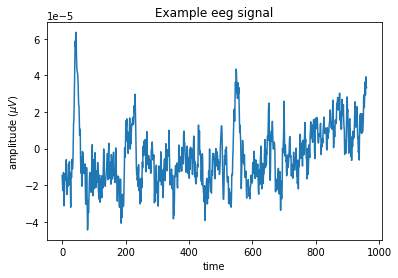

In [290]:
plt.plot(X[0, 0, 1,:])
plt.title('Example eeg signal')
plt.xlabel('time')
plt.ylabel('amplitude ($\mu V$)' )
plt.show()

Due to small value of EEG signal regarding to X. the values will be scaled up. Actually, the signal values are the micro volt ($10^{-6}$) unit converted to volt. So that, the value should be rescaled to micro volt again to a scale of a unit of +1.0 or -1.0.

In [291]:
X = X * 1e6
X[0]

array([[[ -9.61501826, -18.5258701 , -25.71676924, ...,  25.82450948,
          18.74663268,  22.93878841],
        [-14.79489807, -18.92563973, -22.89842409, ...,  39.20895931,
          33.30792024,  33.32504653],
        [ -1.98396103,  -4.96640882,  -8.07066099, ...,  38.4661162 ,
          36.6061316 ,  36.55881692],
        ...,
        [ -0.23939714,  -3.78497856,  -9.3282746 , ...,  15.71967982,
          16.42932197,   8.7307248 ],
        [ -2.54152187,  -5.95979818, -12.5982    , ...,  30.16034587,
          28.82862262,  22.14322294],
        [-11.09940658, -11.72418461, -17.17073874, ...,  26.90879114,
          25.59742723,  17.85376261]]])

Next function is to prepare X and y as numpy array into pytorch DataLoader

In [292]:
def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

Before Loading data into DataLoader, split X and y into train set and test (validation) set.

In [293]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

print('X_train shape: ',X_train.shape)
print('X_test shape: ',X_test.shape)
print('y_train shape: ',y_train.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (315, 1, 21, 961)
X_test shape:  (105, 1, 21, 961)
y_train shape:  (315,)
y_test shape:  (105,)


Load training set and test set for DataLoader

In [294]:
train_loader = Xy_dataloader(X_train, y_train, 16)
test_loader = Xy_dataloader(X_test, y_test, 16)

# 3. Modeling

Modeling section will make spatio-temporal CNN based. 

In [295]:
class CNNTempoSpatio(nn.Module):
    
    def __init__(self, input_chan,n_chan, output_dim):
        super().__init__()
        
        self.conv_tempo1 = nn.Sequential(
            nn.Conv2d(input_chan, 40, kernel_size=(1,30), stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )

        self.conv_spatio = nn.Sequential(
            nn.Conv2d(40, 40, kernel_size=(n_chan, 1), stride=1, padding='valid'),
            nn.ReLU(),
            nn.Dropout2d(0.5)
        )
            
        self.avg_pool = nn.AvgPool2d(kernel_size=(1, 15), stride=(1, 1))

        self.fc = nn.Linear(40*947, 80)

        self.fc_out = nn.Linear(80, output_dim)

        
    def forward(self, x):
        
        x = self.conv_tempo1(x)
        # print(x.shape)
  

        x = self.conv_spatio(x)
        # print(x.shape)

        x = self.avg_pool(x)
        # print(x.shape)

        x = x.reshape(x.size(0), -1)

        x = self.fc(x)

        x = self.fc_out(x)

        return x

# 4. Training Model

Before constructing model instance, check wheter GPU is work or not

In [296]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('pytorch is using: ', device)

pytorch is using:  cuda


Create Model instance

In [297]:
model = CNNTempoSpatio(1,21, 2).to(device)

Define Optimizer and Loss function

In [298]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Define Xavier initialization which helps init weight better to prevent model training from gradient vanishing or exploding

In [299]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param) #<---here
                
model.apply(initialize_weights)

CNNTempoSpatio(
  (conv_tempo1): Sequential(
    (0): Conv2d(1, 40, kernel_size=(1, 30), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
  )
  (conv_spatio): Sequential(
    (0): Conv2d(40, 40, kernel_size=(21, 1), stride=(1, 1), padding=valid)
    (1): ReLU()
    (2): Dropout2d(p=0.5, inplace=False)
  )
  (avg_pool): AvgPool2d(kernel_size=(1, 15), stride=(1, 1), padding=0)
  (fc): Linear(in_features=37880, out_features=80, bias=True)
  (fc_out): Linear(in_features=80, out_features=2, bias=True)
)

Lets define the training function with validation set

In [300]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()

#             clipping_value = 0.9 # arbitrary value of your choosing
#             torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

Train model

epoch 100/100 train loss: 0.19918 train acc: 91.74603271484375 validation loss: 0.33445 validation acc: 80.95237731933594


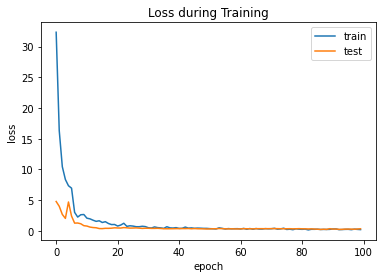

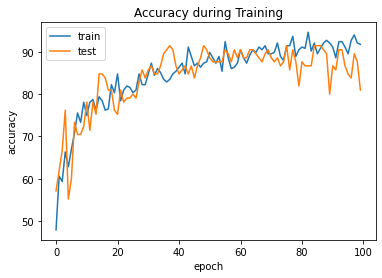

In [301]:
model, loss_train, loss_valid, acc_train, acc_valid = train_model(model, train_loader, test_loader, 100, criterion, optimizer, 1)

# 5. Model Evaluation

In [302]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [303]:
y_pred = predict_model(model, X_test)

In [304]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79        52
           1       0.76      0.91      0.83        53

    accuracy                           0.81       105
   macro avg       0.82      0.81      0.81       105
weighted avg       0.82      0.81      0.81       105



Unmount the drive

In [ ]:
drive.flush_and_unmount()